## **Dataset**

In [4]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if image_name not in captions:
                captions[image_name] = caption
        if image_name == "image_08128":
            break
    return captions

In [5]:
captions_folder = "data/cvpr2016_flowers/captions"
image_folder = "data/cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

In [6]:
len(captions)

8128

## **Caption Encoder**

In [7]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
        
    return encoded_captions

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
encoded_captions = encode_captions(captions)

## **Preprocessing**

In [9]:
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']

        return {
            'image': image,
            'embed_caption': encoded_caption,
            'text': caption
        }

In [10]:
import torchvision.transforms as transforms

IMG_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="data/cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [11]:
import matplotlib.pyplot as plt

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


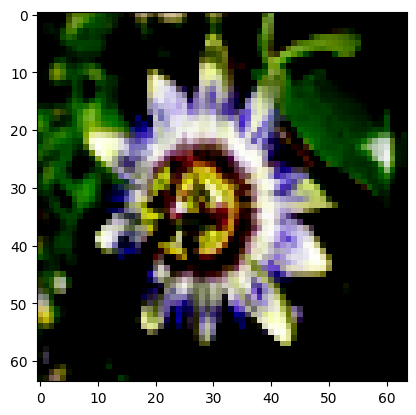

In [12]:
show_grid(next(iter(ds))['image'])

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
batch_sample = next(iter(dataloader))

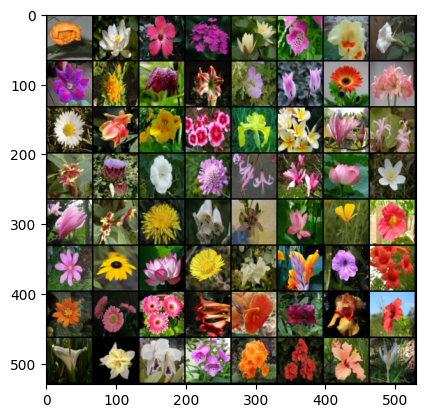

In [15]:
import torchvision

show_grid(torchvision.utils.make_grid(batch_sample['image'], normalize=True))

## **Model**

In [16]:
import torch.nn as nn

class Generator(nn.Module):

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        ### Your Code Here
        # Reduce dim size for embedding vectors of captiopn
        self.reduced_dim_size = reduced_dim_size
        self.text_encoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=self.reduced_dim_size),
            nn.BatchNorm1d(num_features=self.reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.upSampler = nn.Sequential(
            nn.ConvTranspose2d(in_channels=reduced_dim_size + noise_size, out_channels=feature_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 4),
            nn.GELU(),

            nn.ConvTranspose2d(in_channels=feature_size * 4, out_channels=feature_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 2),
            nn.GELU(),

            nn.ConvTranspose2d(in_channels=feature_size * 2, out_channels=feature_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size),
            nn.GELU(),

            nn.ConvTranspose2d(in_channels=feature_size, out_channels= int(feature_size/2), kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=int(feature_size/2)),
            nn.GELU(),

            nn.ConvTranspose2d(in_channels=int(feature_size/2), out_channels= int(feature_size/4), kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=int(feature_size/4)),
            nn.GELU(),

            nn.ConvTranspose2d(in_channels=int(feature_size/4), out_channels= num_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()          
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.text_encoder(text_embeddings)
        input_vector = torch.cat([noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2)
        output = self.upSampler(input_vector)
        return output

In [17]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        ### Your Code Here
        self.reduced_dim_size = reduced_dim_size

        self.image_encoder = nn.Sequential(
            # 3 -> 128
            nn.Conv2d(in_channels=num_channels, out_channels=feature_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size),
            nn.GELU(),

            # 128 -> 128
            nn.Conv2d(in_channels=feature_size, out_channels=feature_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=feature_size),
            nn.GELU(),

            # 128 -> 256 
            nn.Conv2d(in_channels=feature_size, out_channels=feature_size * 2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 2),
            nn.GELU(),

            # 256 -> 256 
            nn.Conv2d(in_channels=feature_size * 2, out_channels=feature_size * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 2),
            nn.GELU(),

            # 512 -> 512
            nn.Conv2d(in_channels=feature_size * 2, out_channels=feature_size * 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 4),
            nn.GELU(),

            # 512 -> 1024
            nn.Conv2d(in_channels=feature_size* 4, out_channels=feature_size * 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=feature_size * 8),
            nn.GELU(),

        )

        self.text_encoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=self.reduced_dim_size),
            nn.BatchNorm1d(num_features=self.reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(in_channels=feature_size * 8 + reduced_dim_size, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, input_image, text_embedding):
        encoded_image = self.image_encoder(input_image)
        encoded_text = self.text_encoder(text_embedding)
        replicated_text = encoded_text.repeat(4 , 4 , 1 , 1).permute (2, 3, 0, 1)
        input_vector = torch.cat([encoded_image, replicated_text], dim=1)
        output = self.finalBlock(input_vector)
        return output.view(-1, 1), encoded_image

## **Training**

In [18]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [19]:
plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
plt_o_text_embeddings.shape

torch.Size([1, 768])

In [20]:
fixed_noise = torch.randn(size=(1, 100))
fixed_noise.shape

torch.Size([1, 100])

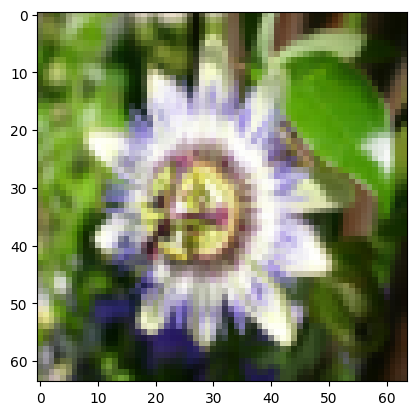

In [21]:
import torchvision

show_grid(torchvision.utils.make_grid(ds[0]['image'], normalize=True))

In [22]:
def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [29]:
generator = Generator(100, 128, 3, 768, 256).to(device)

In [30]:
discriminator = Discriminator(3, 128, 768, 256).to(device)

In [31]:
import torch.optim as optim

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

100%|██████████| 127/127 [00:53<00:00,  2.36it/s]


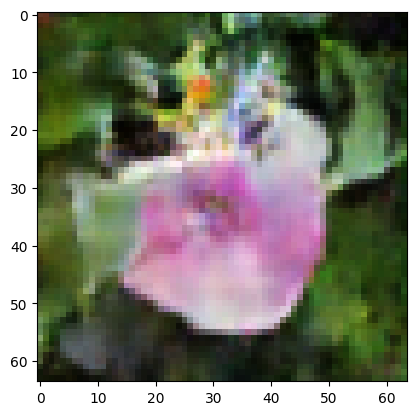

Epoch [1/50] loss_D: 1.4487 loss_G: 27.2225 time: 53.85


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


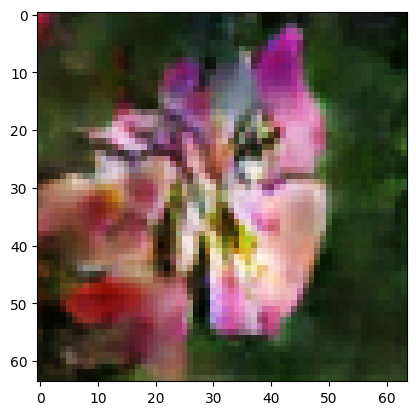

Epoch [2/50] loss_D: 1.4485 loss_G: 27.1927 time: 53.13


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


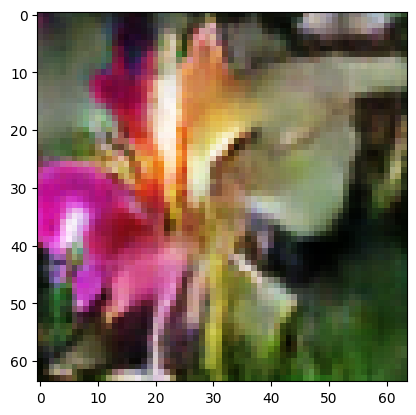

Epoch [3/50] loss_D: 1.4469 loss_G: 27.3545 time: 52.99


100%|██████████| 127/127 [00:52<00:00,  2.41it/s]


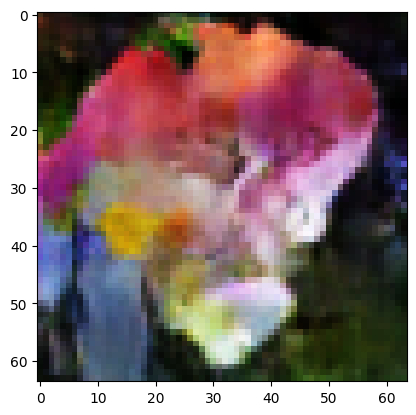

Epoch [4/50] loss_D: 1.4431 loss_G: 27.3726 time: 52.82


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


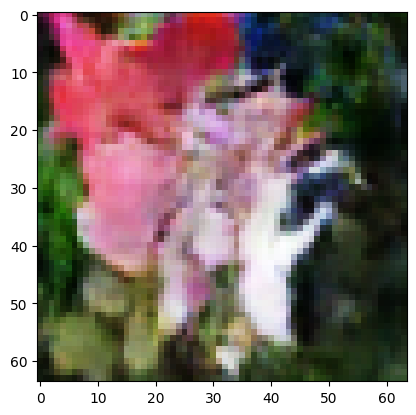

Epoch [5/50] loss_D: 1.4405 loss_G: 27.0237 time: 53.24


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


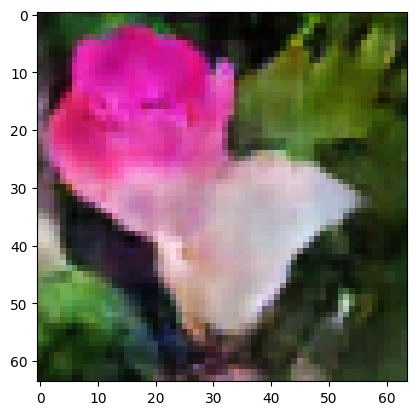

Epoch [6/50] loss_D: 1.4391 loss_G: 27.3669 time: 53.28


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


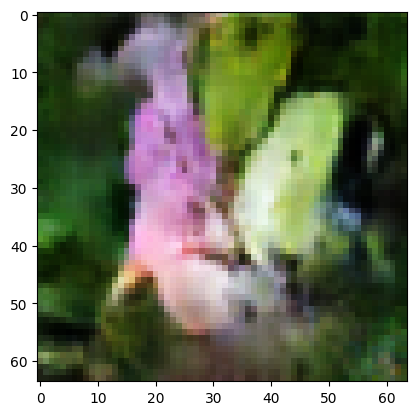

Epoch [7/50] loss_D: 1.4402 loss_G: 27.1354 time: 52.97


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


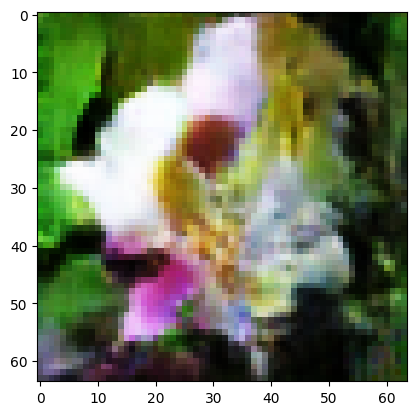

Epoch [8/50] loss_D: 1.4356 loss_G: 27.3132 time: 53.15


100%|██████████| 127/127 [00:52<00:00,  2.41it/s]


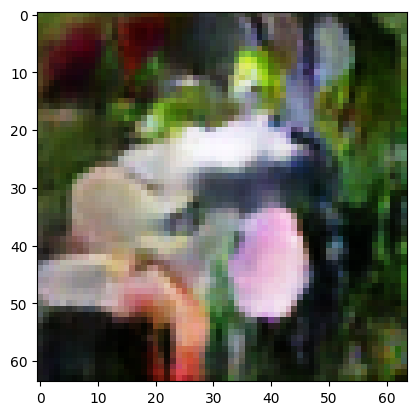

Epoch [9/50] loss_D: 1.4543 loss_G: 26.6702 time: 52.68


100%|██████████| 127/127 [00:52<00:00,  2.41it/s]


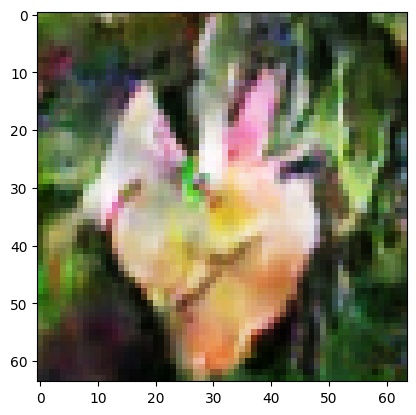

Epoch [10/50] loss_D: 1.4374 loss_G: 27.1043 time: 52.83


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


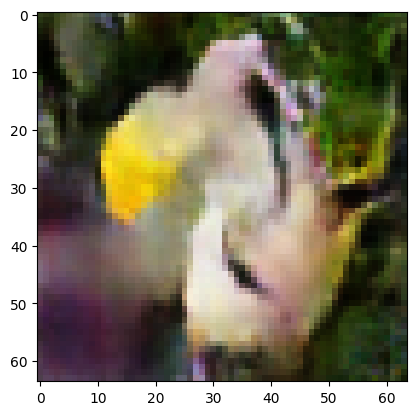

Epoch [11/50] loss_D: 1.4425 loss_G: 27.2068 time: 52.93


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


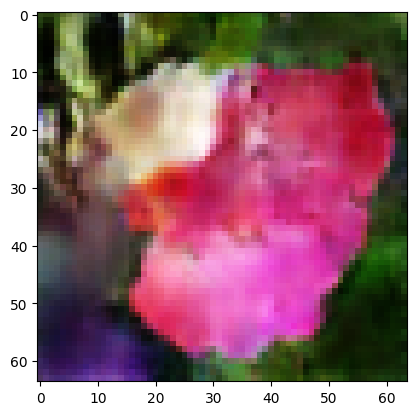

Epoch [12/50] loss_D: 1.4361 loss_G: 27.2743 time: 53.27


100%|██████████| 127/127 [00:56<00:00,  2.25it/s]


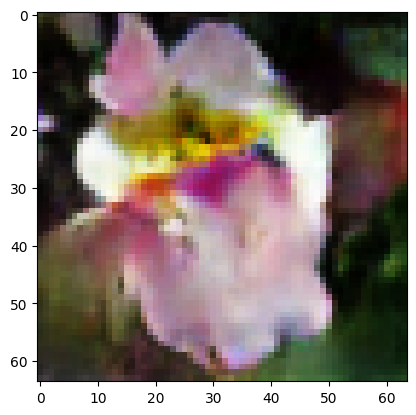

Epoch [13/50] loss_D: 1.4312 loss_G: 27.1411 time: 56.49


100%|██████████| 127/127 [00:53<00:00,  2.37it/s]


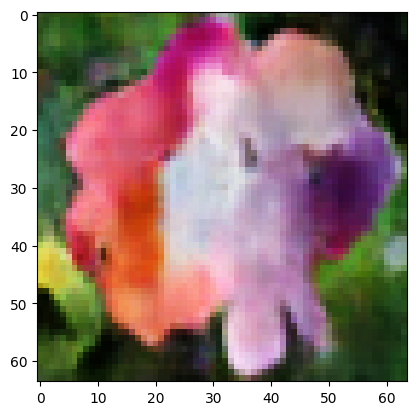

Epoch [14/50] loss_D: 1.4339 loss_G: 27.2122 time: 53.75


100%|██████████| 127/127 [00:53<00:00,  2.39it/s]


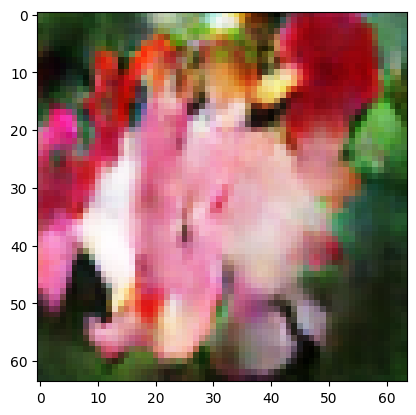

Epoch [15/50] loss_D: 1.4293 loss_G: 27.4347 time: 53.21


100%|██████████| 127/127 [00:52<00:00,  2.41it/s]


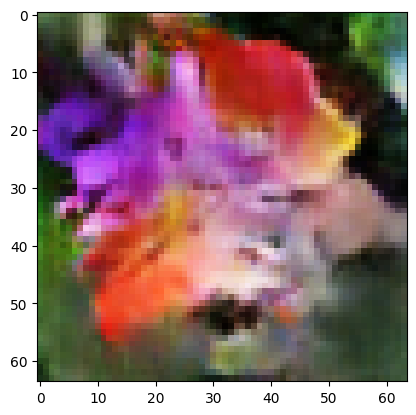

Epoch [16/50] loss_D: 1.4280 loss_G: 27.2166 time: 52.82


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


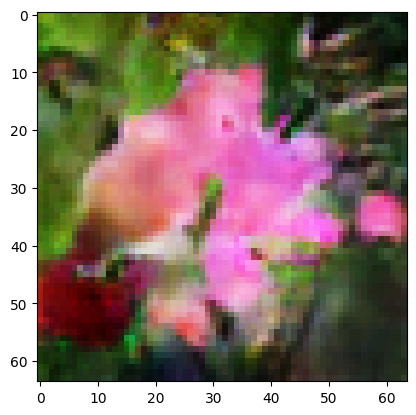

Epoch [17/50] loss_D: 1.4435 loss_G: 27.1004 time: 52.90


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


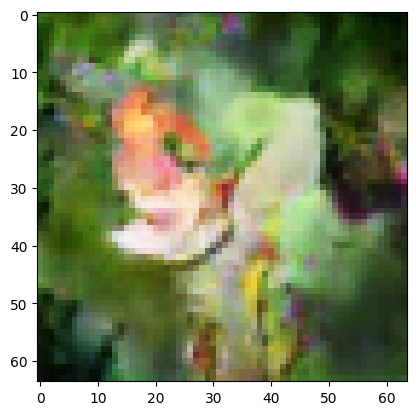

Epoch [18/50] loss_D: 1.4468 loss_G: 27.1046 time: 53.08


100%|██████████| 127/127 [00:53<00:00,  2.38it/s]


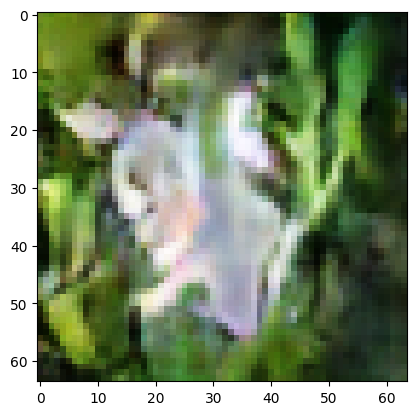

Epoch [19/50] loss_D: 1.4339 loss_G: 27.2382 time: 53.54


100%|██████████| 127/127 [00:54<00:00,  2.34it/s]


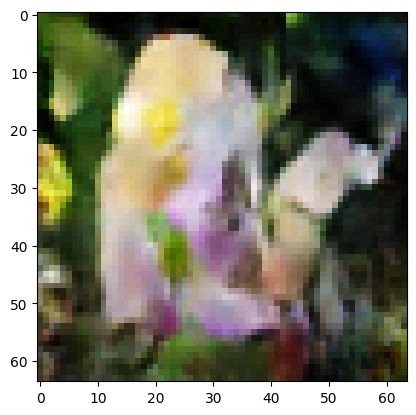

Epoch [20/50] loss_D: 1.4549 loss_G: 26.8505 time: 54.28


100%|██████████| 127/127 [00:53<00:00,  2.40it/s]


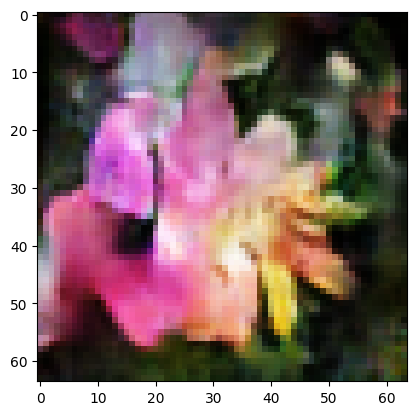

Epoch [21/50] loss_D: 1.4457 loss_G: 26.3246 time: 53.11


100%|██████████| 127/127 [00:53<00:00,  2.38it/s]


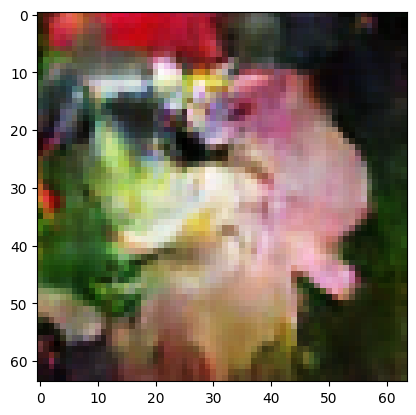

Epoch [22/50] loss_D: 1.4425 loss_G: 26.3615 time: 53.39


100%|██████████| 127/127 [00:53<00:00,  2.38it/s]


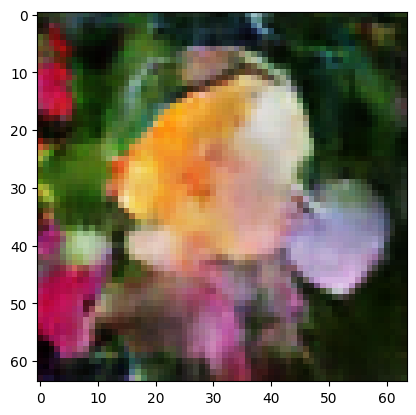

Epoch [23/50] loss_D: 1.4363 loss_G: 26.6920 time: 53.41


100%|██████████| 127/127 [00:54<00:00,  2.34it/s]


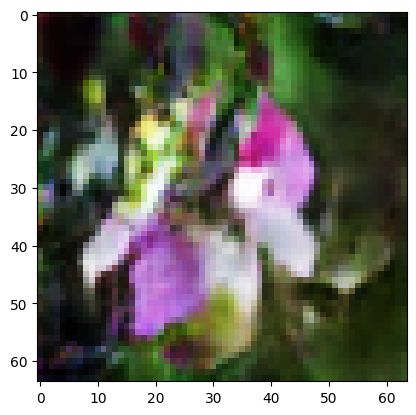

Epoch [24/50] loss_D: 1.4415 loss_G: 26.6839 time: 54.30


100%|██████████| 127/127 [00:53<00:00,  2.38it/s]


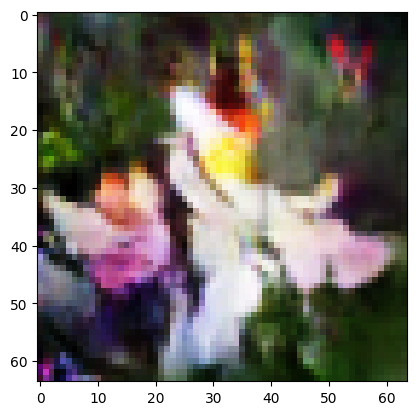

Epoch [25/50] loss_D: 1.4316 loss_G: 26.8980 time: 53.47


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


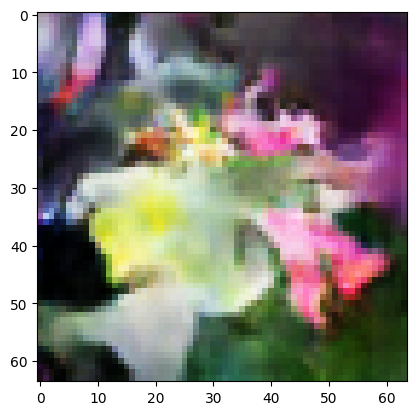

Epoch [26/50] loss_D: 1.4320 loss_G: 26.8401 time: 53.04


100%|██████████| 127/127 [00:59<00:00,  2.15it/s]


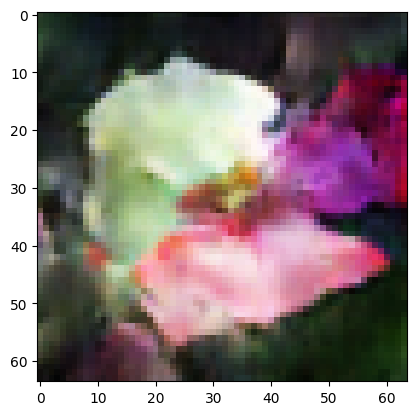

Epoch [27/50] loss_D: 1.4283 loss_G: 26.7863 time: 59.30


100%|██████████| 127/127 [01:07<00:00,  1.89it/s]


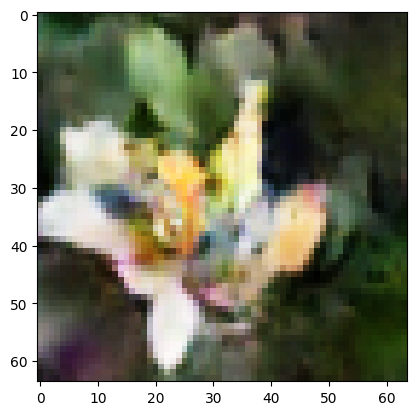

Epoch [28/50] loss_D: 1.4321 loss_G: 26.4864 time: 67.48


100%|██████████| 127/127 [01:05<00:00,  1.94it/s]


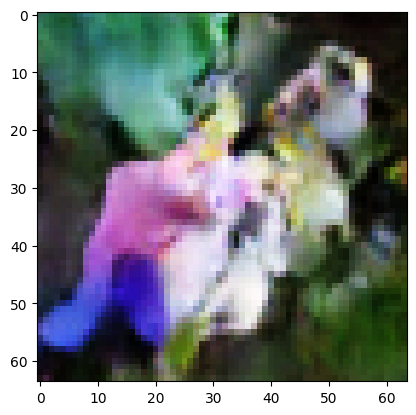

Epoch [29/50] loss_D: 1.4385 loss_G: 26.8847 time: 65.65


100%|██████████| 127/127 [01:06<00:00,  1.92it/s]


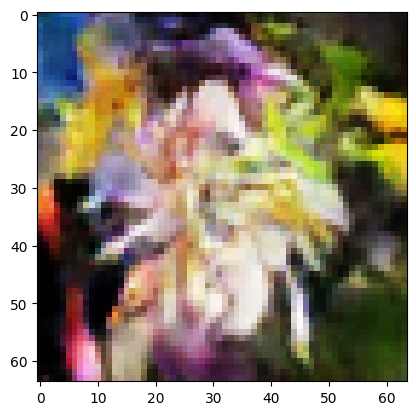

Epoch [30/50] loss_D: 1.4281 loss_G: 26.8230 time: 66.32


100%|██████████| 127/127 [00:55<00:00,  2.30it/s]


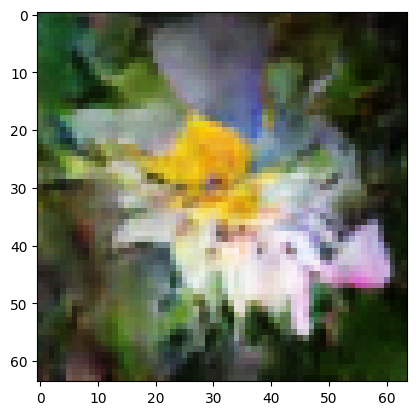

Epoch [31/50] loss_D: 1.4282 loss_G: 27.0675 time: 55.40


100%|██████████| 127/127 [01:10<00:00,  1.81it/s]


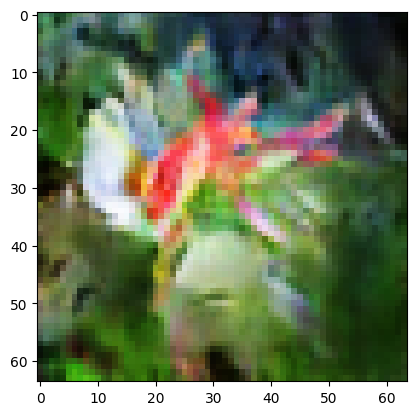

Epoch [32/50] loss_D: 1.4388 loss_G: 26.6239 time: 70.28


100%|██████████| 127/127 [01:15<00:00,  1.69it/s]


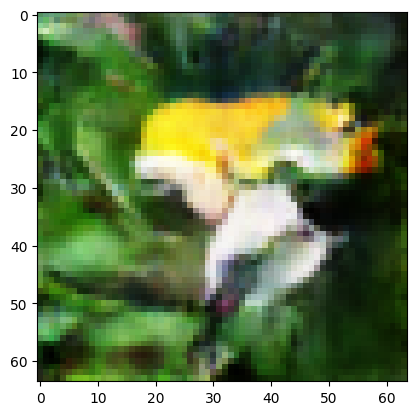

Epoch [33/50] loss_D: 1.4313 loss_G: 26.8799 time: 75.41


100%|██████████| 127/127 [00:54<00:00,  2.33it/s]


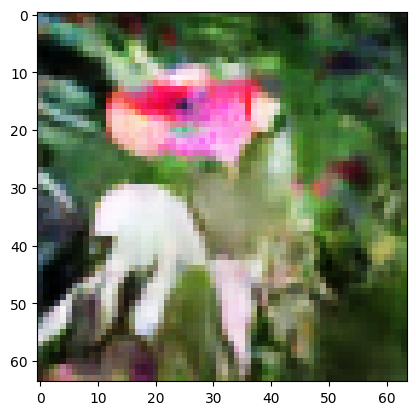

Epoch [34/50] loss_D: 1.4330 loss_G: 26.9787 time: 54.54


100%|██████████| 127/127 [00:58<00:00,  2.16it/s]


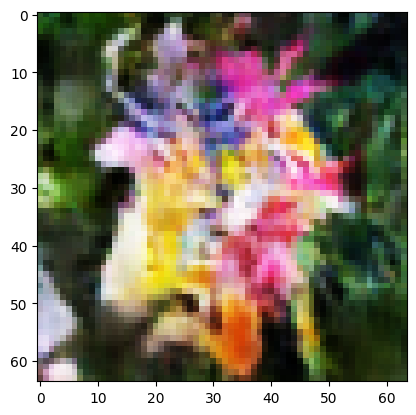

Epoch [35/50] loss_D: 1.4306 loss_G: 26.8909 time: 58.87


100%|██████████| 127/127 [00:55<00:00,  2.30it/s]


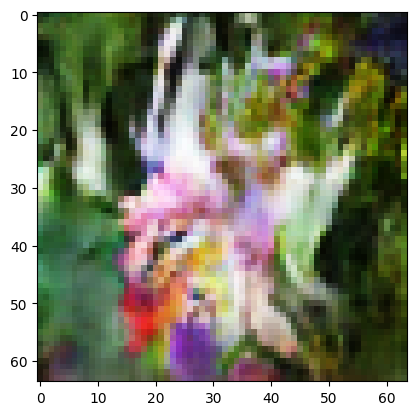

Epoch [36/50] loss_D: 1.4279 loss_G: 26.3147 time: 55.36


100%|██████████| 127/127 [01:01<00:00,  2.06it/s]


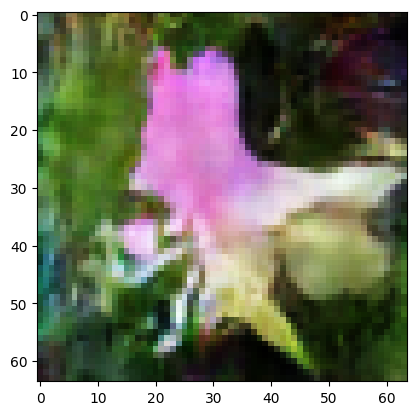

Epoch [37/50] loss_D: 1.4296 loss_G: 26.5063 time: 61.65


100%|██████████| 127/127 [01:06<00:00,  1.91it/s]


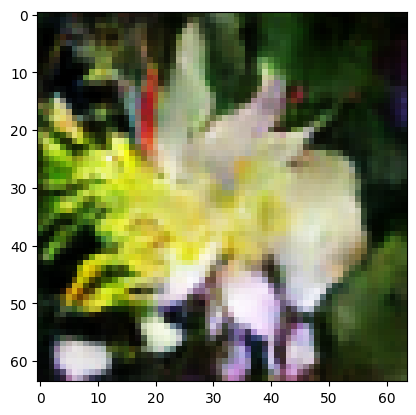

Epoch [38/50] loss_D: 1.4330 loss_G: 26.7189 time: 66.68


100%|██████████| 127/127 [01:08<00:00,  1.86it/s]


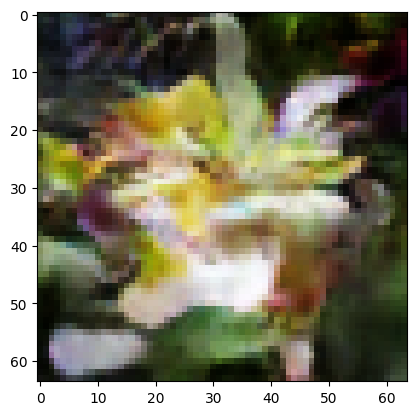

Epoch [39/50] loss_D: 1.4286 loss_G: 26.7913 time: 68.23


100%|██████████| 127/127 [00:59<00:00,  2.13it/s]


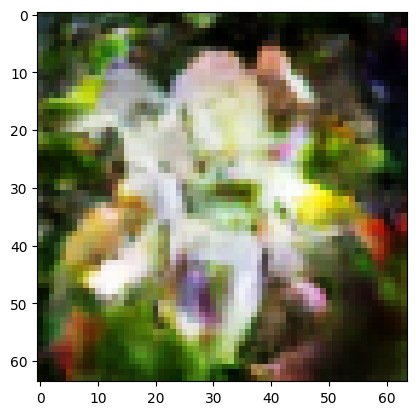

Epoch [40/50] loss_D: 1.4500 loss_G: 25.9954 time: 59.87


100%|██████████| 127/127 [00:59<00:00,  2.12it/s]


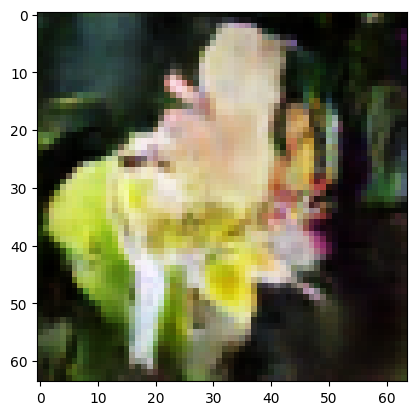

Epoch [41/50] loss_D: 1.4402 loss_G: 26.3459 time: 59.90


100%|██████████| 127/127 [00:56<00:00,  2.27it/s]


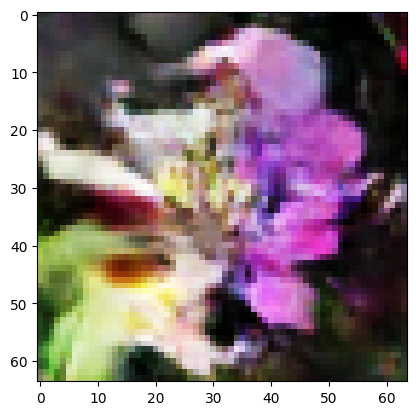

Epoch [42/50] loss_D: 1.4285 loss_G: 26.7643 time: 56.14


100%|██████████| 127/127 [00:54<00:00,  2.34it/s]


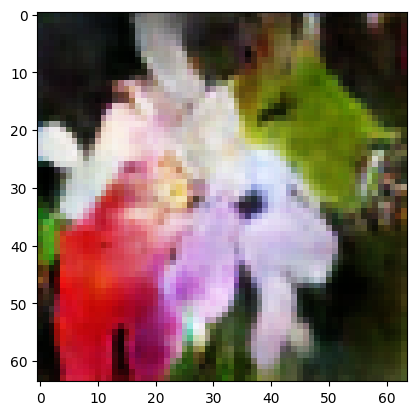

Epoch [43/50] loss_D: 1.4279 loss_G: 26.4404 time: 54.31


100%|██████████| 127/127 [00:54<00:00,  2.34it/s]


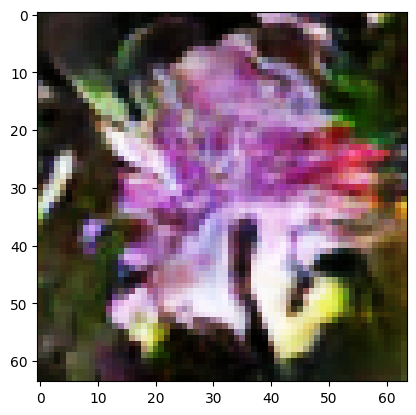

Epoch [44/50] loss_D: 1.4520 loss_G: 25.8693 time: 54.36


100%|██████████| 127/127 [00:59<00:00,  2.14it/s]


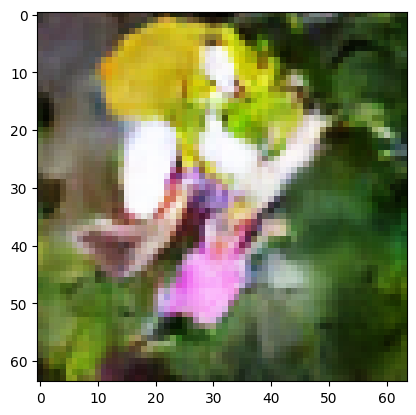

Epoch [45/50] loss_D: 1.4274 loss_G: 26.4561 time: 59.34


100%|██████████| 127/127 [00:57<00:00,  2.21it/s]


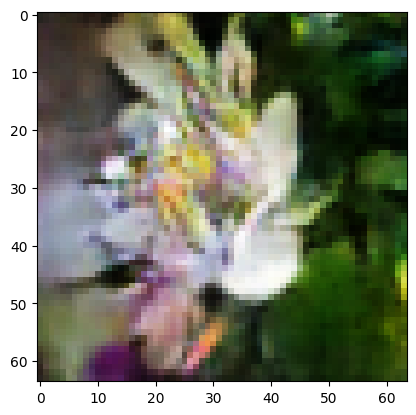

Epoch [46/50] loss_D: 1.4255 loss_G: 26.5630 time: 57.67


100%|██████████| 127/127 [01:16<00:00,  1.67it/s]


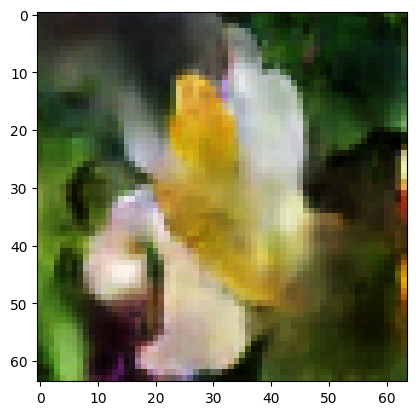

Epoch [47/50] loss_D: 1.4229 loss_G: 26.7523 time: 76.16


100%|██████████| 127/127 [00:53<00:00,  2.37it/s]


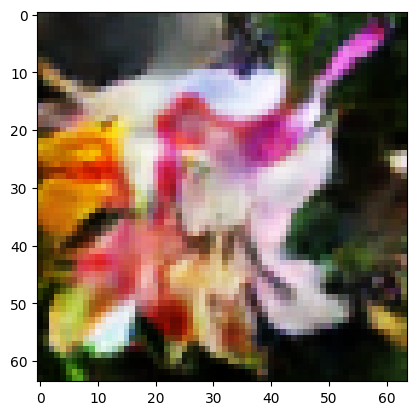

Epoch [48/50] loss_D: 1.4262 loss_G: 26.5973 time: 53.69


100%|██████████| 127/127 [00:52<00:00,  2.40it/s]


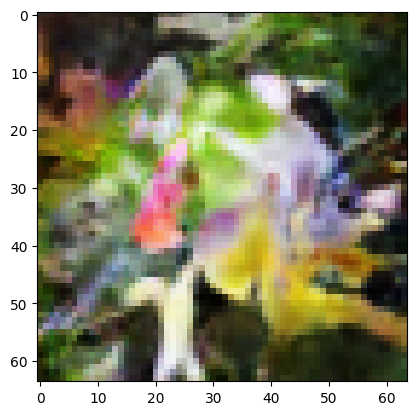

Epoch [49/50] loss_D: 1.4268 loss_G: 26.6198 time: 53.00


100%|██████████| 127/127 [01:08<00:00,  1.85it/s]


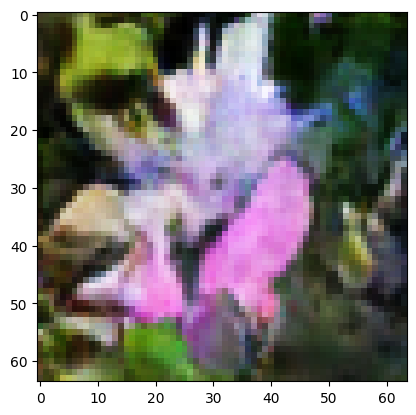

Epoch [50/50] loss_D: 1.4296 loss_G: 26.6672 time: 68.76


In [33]:
import time
from tqdm import tqdm

epochs = 50

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in tqdm(dataloader):

        ### Your Code Here
        images = batch["image"].to(device)
        caption_embeddings =  batch['embed_caption'].to(device)
        
        #Create wrong image
        wrong_images = images[torch.randperm(64), :, :, :].to(device)

        # Generate fake image
        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = generator(noise, caption_embeddings)

        # Training discriminator
        optimizer_D.zero_grad()

        # Create labels
        real_labels = torch.ones(images.size(0), 1, device=device) #  (batch_size, 1)
        fake_labels = torch.zeros(images.size(0), 1, device=device) #  (batch_size, 1)
        
        labels, _ = discriminator(images, caption_embeddings)
        real_loss = bce_loss(labels, real_labels)

        labels, _ = discriminator(fake_images.detach().to(device), caption_embeddings)
        fake_loss = bce_loss(labels, fake_labels)

        labels, _ = discriminator(wrong_images, caption_embeddings)
        wrong_loss = bce_loss(labels, fake_labels)

        # Calculate discriminator loss
        d_loss = real_loss + fake_loss + wrong_loss
        
        d_loss.backward()
        optimizer_D.step()
        d_losses.append(d_loss.item())


        # Training generator
        optimizer_G.zero_grad()

        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = generator(noise, caption_embeddings)

        _, feature_real = discriminator(images, caption_embeddings)
        outputs, feature_fake = discriminator(fake_images, caption_embeddings)

        activation_real = torch.mean(feature_real, 0)
        activation_fake = torch.mean(feature_fake, 0)

        real_loss = bce_loss(outputs, real_labels)
        g_loss = real_loss + 100 * l2_loss(activation_fake ,activation_real.detach()) + 50 * l1_loss(fake_images, images)
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(g_loss.item())


    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    plot_output(generator)


    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

## **Prediction**

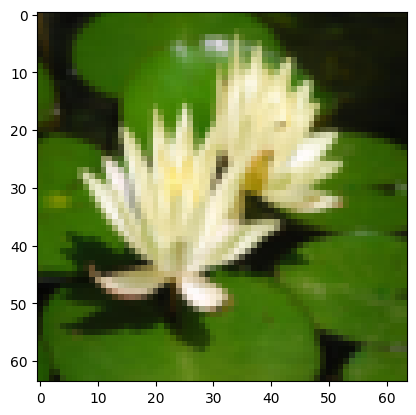

In [47]:
show_grid(torchvision.utils.make_grid(ds[402]['image'], normalize=True))

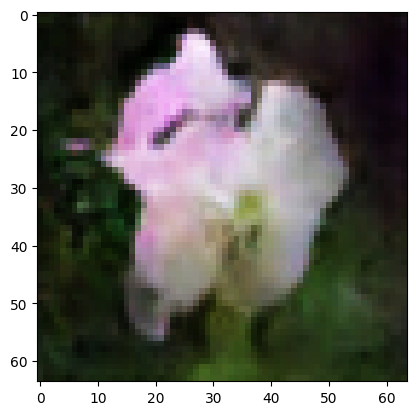

In [46]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[402]['embed_caption'].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))
grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)

## Evaluation

In [49]:
import torch

# Save generator
torch.save(generator.state_dict(), 'generator.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator.pth')